In [31]:
%config IPCompleter.greedy=True

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import chainer

In [34]:
chainer.print_runtime_info()

Platform: Windows-10-10.0.17134-SP0
Chainer: 5.4.0
NumPy: 1.16.2
CuPy:
  CuPy Version          : 5.4.0
  CUDA Root             : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.0
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7500
  cuDNN Version         : 7500
  NCCL Build Version    : None
  NCCL Runtime Version  : None
iDeep: Not Available


In [35]:
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)

print('x:', x.shape)
print('t:', t.shape)

x: (150, 4)
t: (150,)


In [36]:
x = x.astype('float32')
t = t.astype('int32')

In [37]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

In [38]:
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [39]:
import chainer.links as L
import chainer.functions as F

In [40]:
from chainer import Sequential

n_input, n_hidden, n_output = 4, 6, 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [41]:
optimizer = chainer.optimizers.SGD(lr=0.05)

In [42]:
optimizer.setup(net)

In [43]:
n_epoch = 30
n_batchsize = 16

In [44]:
import numpy as np

In [45]:
iteration = 0

results_train = {
    'loss': [],
    'accuracy': []
}

results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):
    order = np.random.permutation(range(len(x_train)))
    
    loss_list = []
    accuracy_list = []
    
    for i in range(0, len(order), n_batchsize):
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index, :]
        t_train_batch = t_train[index]
        
        y_train_batch = net(x_train_batch)
        
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)
        
        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)
        
        net.cleargrads()
        loss_train_batch.backward()
        
        optimizer.update()
        
        iteration += 1
    
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)
    
    with chainer.using_config('train', False), chainer.using_config('enable_backdrop', False):
        y_val = net(x_val)
    
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)
    
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))
    
    results_train['loss'].append(loss_train)
    results_train['accuracy'].append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 5, loss (train): 1.3144, loss (valid): 1.1588
epoch: 1, iteration: 10, loss (train): 1.1133, loss (valid): 1.1418
epoch: 2, iteration: 15, loss (train): 1.0548, loss (valid): 1.1760
epoch: 3, iteration: 20, loss (train): 1.0596, loss (valid): 1.1484
epoch: 4, iteration: 25, loss (train): 1.0471, loss (valid): 1.1224
epoch: 5, iteration: 30, loss (train): 1.0536, loss (valid): 1.1257
epoch: 6, iteration: 35, loss (train): 1.0259, loss (valid): 1.1428
epoch: 7, iteration: 40, loss (train): 1.0658, loss (valid): 1.1111
epoch: 8, iteration: 45, loss (train): 1.0354, loss (valid): 1.1634
epoch: 9, iteration: 50, loss (train): 1.0452, loss (valid): 1.1575
epoch: 10, iteration: 55, loss (train): 1.0339, loss (valid): 1.0875
epoch: 11, iteration: 60, loss (train): 1.0071, loss (valid): 1.1782
epoch: 12, iteration: 65, loss (train): 1.0043, loss (valid): 1.1122
epoch: 13, iteration: 70, loss (train): 0.9844, loss (valid): 1.1316
epoch: 14, iteration: 75, loss (train): 1.019

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

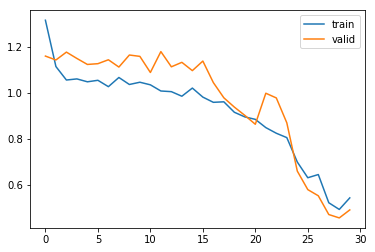

In [48]:
plt.plot(results_train['loss'], label='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()

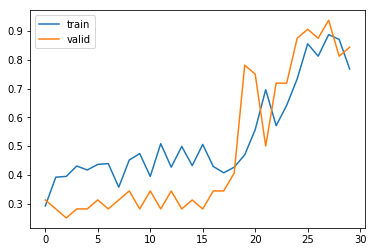

In [49]:
plt.plot(results_train['accuracy'], label='train')
plt.plot(results_valid['accuracy'], label='valid')
plt.legend()

In [50]:
with chainer.using_config('train', False), chainer.using_config('enable_backdrop', False):
    y_test = net(x_test)

In [52]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.64444447, dtype=float32)

In [53]:
chainer.serializers.save_npz('my_iris.net', net)

In [54]:
!ls

ChainerTutorial.ipynb
my_iris.net


In [55]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [56]:
chainer.serializers.load_npz('my_iris.net', loaded_net)

In [57]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

In [61]:
np.argmax(y_test[0, :].array)

2